In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from hmmlearn import hmm
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
import functions_data_processing as fsd
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from itertools import combinations
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import TimeSeriesSplit
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier

In [2]:
def compute_metrics(y_true, y_predicted):
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_predicted)
    precision = sklearn.metrics.precision_score(y_true, y_predicted)
    recall = sklearn.metrics.recall_score(y_true, y_predicted)
    f1 = sklearn.metrics.f1_score(y_true, y_predicted)
    accuracy = sklearn.metrics.accuracy_score(y_true, y_predicted)
    
    return {"confusion matrix ": confusion_matrix, "precision ": precision, "recall ": recall, "f1 ": f1, "accuracy " : accuracy}

In [3]:
# Branje datoteke CSV, nastavljanje visokih vrednosti na 1 in nizkih vrednosti na 0 ter izdelava novega stolpca poimenovanega "Mikrovalovna pečica - Privzeto (združeno)".

df_imported = pd.read_csv("df.csv", index_col=0)
df_imported = df_imported
df_imported.index = pd.to_datetime(df_imported.index)
df = pd.DataFrame()
df["Microwave"] = df_imported["Microwave"]
df["Default"] = df_imported["Default"]
df["Ground Truth"] = df_imported["Ground Truth"]
df["Microwave - Default (combined)"] = "temporary"
df["Garage door"] = df_imported["Garage door"]

df = df.mask(df == 0.9, 1)
df = df.mask(df == 0.1, 0)

mask1 = (df["Microwave"] == 1.0) & (df["Default"] == 1.0)
mask2 = (df["Microwave"] == 0.0) & (df["Default"] == 1.0)
mask3 = (df["Microwave"] == 0.0) & (df["Default"] == 0.0)
mask4 = (df["Microwave"] == 1.0) & (df["Default"] == 0.0)

df["Microwave - Default (combined)"] = ""
df["Microwave - Default (combined)"] = df["Microwave - Default (combined)"].mask(
    mask1, 3
)
df["Microwave - Default (combined)"] = df["Microwave - Default (combined)"].mask(
    mask2, 1
)
df["Microwave - Default (combined)"] = df["Microwave - Default (combined)"].mask(
    mask3, 0
)
df["Microwave - Default (combined)"] = df["Microwave - Default (combined)"].mask(
    mask4, 2
)
df.head()

,Microwave,Default,Ground Truth,Microwave - Default (combined),Garage door
2016-01-01 05:00:00,0.0,1.0,1.0,1,0.0
2016-01-01 05:01:00,0.0,1.0,1.0,1,0.0
2016-01-01 05:02:00,0.0,1.0,1.0,1,0.0
2016-01-01 05:03:00,0.0,1.0,1.0,1,0.0
2016-01-01 05:04:00,0.0,1.0,1.0,1,0.0


In [4]:
# A function that returns a data frame with a specified interval length and starting date
def interval_model(data_frame, starting_date, interval):

    s_date = pd.to_datetime(starting_date, format="%Y-%m-%d %H:%M:%S.%f")
    data_frame = data_frame.loc[s_date : s_date + interval]
    return data_frame

In [5]:
# Prvi teden 
df_sensors_w1 = interval_model(
    data_frame=df["Microwave - Default (combined)"],
    starting_date="2016-01-01 05:00:00",
    interval=datetime.timedelta(days=7),
)
df_sensors_w1 = df_sensors_w1.astype(int)

# Prvi teden ground truth

df_truth_w1 = interval_model(
    data_frame=df['Ground Truth'],
    starting_date="2016-01-01 05:00:00",
    interval=datetime.timedelta(days=7),
)


# Drugi teden


df_sensors_w2 = interval_model(
    data_frame=df["Microwave - Default (combined)"],
    starting_date="2016-01-07 05:00:00",
    interval=datetime.timedelta(days=7),
)
df_sensors_w2 = df_sensors_w2.astype(int)

# Drugi teden ground truth
df_truth_w2 = interval_model(
    data_frame=df["Ground Truth"],
    starting_date="2016-01-07 05:00:00",
    interval=datetime.timedelta(days=7),
)

### Week 1

In [6]:
model = hmm.CategoricalHMM(n_components=2, n_iter=100, init_params="ste", params="ste")
X1 = np.array(df_sensors_w1).reshape(-1, 1)
model.fit(X1)

CategoricalHMM(n_components=2, n_iter=100,
               random_state=RandomState(MT19937) at 0x72AC0CFA9540)

In [7]:
print("Starting probabilities\n ", model.startprob_, "\n")
print("Transition probabilities\n ", model.transmat_, "\n")
print("Emission probabilities\n ", model.emissionprob_, "\n")

Starting probabilities
  [8.56419081e-35 1.00000000e+00] 

Transition probabilities
  [[0.99848485 0.00151515]
 [0.00128205 0.99871795]] 

Emission probabilities
  [[9.95887446e-01 6.06961738e-13 4.11255411e-03 2.14220100e-24]
 [2.11463741e-12 9.87548068e-01 2.85951951e-23 1.24519319e-02]] 



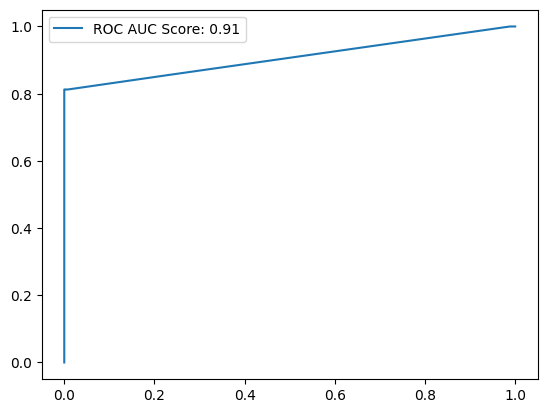

In [8]:
predictions = model.predict_proba(X1)


# Compute ROC curve
fpr, tpr, thresholds = roc_curve(np.array(df_truth_w1), predictions[:,1], pos_label=1)

# Print fpr and tpr
# print("Fpr ", fpr)
# print("Tpr ", tpr)

# print(thresholds)
plt.plot(fpr, tpr)
plt.legend(
    [
        "ROC AUC Score: {:.2f}".format(
            roc_auc_score(np.array(df_truth_w1), predictions[:, 1])
        )
    ]
)

plt.show()

In [9]:
print(compute_metrics(np.array(df_truth_w1), model.predict(X1)))

{'confusion matrix ': array([[3360,    0],
       [1260, 5461]]), 'precision ': 1.0, 'recall ': 0.8125278976342806, 'f1 ': 0.8965687079297324, 'accuracy ': 0.8750123995635354}


What if we build another model, however this time, we take the initial values for the starting, transition and emission probabilities from the learnt values from the previous model?

In [10]:
model_with_initial = hmm.CategoricalHMM(n_components=2, n_iter=100, init_params="", params="ste")
model_with_initial.startprob_ = model.startprob_
model_with_initial.transmat_ = model.transmat_
model_with_initial.emissionprob_ = model.emissionprob_
model_with_initial.fit(X1)

CategoricalHMM(init_params='', n_components=2, n_iter=100,
               random_state=RandomState(MT19937) at 0x72AC0CFA9540)

In [11]:
print("Starting probabilities\n ", model_with_initial.startprob_, "\n")
print("Transition probabilities\n ", model_with_initial.transmat_, "\n")
print("Emission probabilities\n ", model_with_initial.emissionprob_, "\n")

Starting probabilities
  [2.28617742e-67 1.00000000e+00] 

Transition probabilities
  [[0.99848485 0.00151515]
 [0.00128205 0.99871795]] 

Emission probabilities
  [[9.95887446e-01 5.72194115e-18 4.11255411e-03 1.13519932e-35]
 [1.40373151e-17 9.87548068e-01 7.76943913e-35 1.24519319e-02]] 



### Week 2

In [12]:
model2 = hmm.CategoricalHMM(n_components=2, n_iter=100, init_params="ste", params="ste")

X2 = np.array(df_sensors_w2).reshape(-1, 1)
model2.fit(X2)

CategoricalHMM(n_components=2, n_iter=100,
               random_state=RandomState(MT19937) at 0x72AC0CFA9540)

In [13]:
print("Starting probabilities\n ", model2.startprob_, "\n")
print("Transition probabilities\n ", model2.transmat_, "\n")
print("Emission probabilities\n ", model2.emissionprob_, "\n")

Starting probabilities
  [4.4699597e-38 1.0000000e+00] 

Transition probabilities
  [[0.99848485 0.00151515]
 [0.00128205 0.99871795]] 

Emission probabilities
  [[9.95670996e-01 1.00660064e-12 4.32900433e-03 4.33483271e-28]
 [2.34419266e-15 9.95238967e-01 2.19632852e-29 4.76103278e-03]] 



[2.00000000e+00 1.00000000e+00 1.00000000e+00 2.35493445e-15
 2.35493445e-15 2.35493445e-15 4.58728740e-21 4.58728740e-21
 4.58728740e-21 4.58728740e-21 4.58728740e-21 4.58728740e-21
 9.88525290e-33 9.88525290e-33 9.88525290e-33]


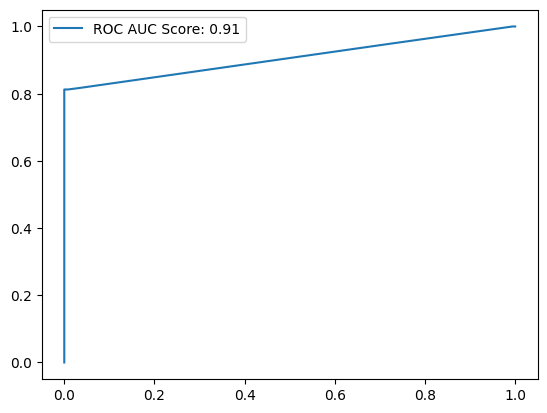

In [14]:
predictions2 = model2.predict_proba(X2)


# Compute ROC curve
fpr, tpr, thresholds = roc_curve(np.array(df_truth_w2), predictions2[:, 1], pos_label=1)

# Print fpr and tpr
# print("Fpr ", fpr)
# print("Tpr ", tpr)

print(thresholds)
plt.plot(fpr, tpr)
plt.legend(
    [
        "ROC AUC Score: {:.2f}".format(
            roc_auc_score(np.array(df_truth_w2), predictions2[:, 1])
        )
    ]
)

plt.show()

In [15]:
print(compute_metrics(np.array(df_truth_w2), model2.predict(X2)))

{'confusion matrix ': array([[3360,    0],
       [1260, 5461]]), 'precision ': 1.0, 'recall ': 0.8125278976342806, 'f1 ': 0.8965687079297324, 'accuracy ': 0.8750123995635354}


In [16]:
predictions[[1,3,5]][:, 0]

array([1.19695775e-18, 1.19695775e-18, 1.19695775e-18])

An important question we have is whether we will get stable results in a cross validation scenario:

In [26]:
model_cross = hmm.CategoricalHMM(n_components=2, n_iter=100, init_params="", params="ste", random_state=105)


tscv = TimeSeriesSplit(n_splits=5, test_size=1000)
st = StratifiedKFold(n_splits=5)
legend_labels = []

for i, (train_index, test_index) in enumerate(st.split(X1, np.array(df_truth_w1))):
    print("Fold ", i)

    model_cross.fit(X1[train_index])
    print("Starting probabilities\n ", model_cross.startprob_, "\n")
    print("Transition probabilities\n ", model_cross.transmat_, "\n")
    print("Emission probabilities\n ", model_cross.emissionprob_, "\n")
    # print(compute_metrics(np.array(df_truth_w1)[test_index], model_cross.predict(X1[test_index])))

    predictions_cross = model.predict_proba(X1)[test_index]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(np.array(df_truth_w1)[test_index], predictions_cross[:, 1], pos_label=1)

    # Print fpr and tpr
    # print("Fpr ", fpr)
    # print("Tpr ", tpr)

    # print(thresholds)
    plt.plot(fpr, tpr)
    auc_score = roc_auc_score(
        np.array(df_truth_w1)[test_index], predictions_cross[:, 1]
    )
    legend_labels.append(f"Fold {i}, ROC AUC Score: {auc_score:.2f}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(legend_labels)

TypeError: StratifiedKFold.split() missing 1 required positional argument: 'y'

Perhaps we can try a supervised type approach such that we find the optimal seed for the random seed for the Dirchlet distribution in order to optimize a certain metric like accuracy, precision, f1 etc.

In [18]:
acc = []
for i in range(1, 2^32):
    model_opt = hmm.CategoricalHMM(n_components=2, n_iter=100, init_params="", params="ste", random_state=i)
    model_opt.fit(X1)
    acc.append(compute_metrics(np.array(df_truth_w1), model_opt.predict(X1))["accuracy "])

/home/nikola/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nikola/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
print(np.max(acc))
print(acc.index(np.max(acc)))

0.8750123995635354
9
